# Module 3 Final Project Submission

Please fill out:
* Student name: David Braslow
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Eli
* Blog post URL: TBD
* Data source: https://www.kaggle.com/kevinarvai/clinvar-conflicting/version/3


# Overview

This project uses a Kaggle dataset to predict gene classifications. In this dataset, we are given multiple genetic variants and various properties of each. Expert raters at different laboratories rated these variants based on their perceived clinical classifications, with ratings ranging from Benign to Pathogenic. The target variable is whether the raters have clinical classifications that are concordant, meaning that they are in the same clinical category.  

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Obtaining the Data

For this project, I downloaded the dataset from the Kaggle page as a csv.

In [2]:
df = pd.read_csv('clinvar_conflicting.csv')
df.head()

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,955563,G,C,0.0000,0.00000,0.0000,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,11.390,1.133255,-2.0
1,1,955597,G,T,0.0000,0.42418,0.2826,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,8.150,0.599088,NaN
2,1,955619,G,C,0.0000,0.03475,0.0088,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,3.288,0.069819,1.0
3,1,957640,C,T,0.0318,0.02016,0.0328,"MedGen:C3808739,OMIM:615120|MedGen:CN169374",NaN,"Myasthenic_syndrome,_congenital,_8|not_specified",...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,12.560,1.356499,NaN
4,1,976059,C,T,0.0000,0.00022,0.0010,MedGen:CN169374,NaN,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.421,17.740,2.234711,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
CHROM                 65188 non-null object
POS                   65188 non-null int64
REF                   65188 non-null object
ALT                   65188 non-null object
AF_ESP                65188 non-null float64
AF_EXAC               65188 non-null float64
AF_TGP                65188 non-null float64
CLNDISDB              65188 non-null object
CLNDISDBINCL          76 non-null object
CLNDN                 65188 non-null object
CLNDNINCL             76 non-null object
CLNHGVS               65188 non-null object
CLNSIGINCL            76 non-null object
CLNVC                 65188 non-null object
CLNVI                 27659 non-null object
MC                    58219 non-null object
ORIGIN                59065 non-null float64
SSR                   104 non-null float64
CLASS                 65188 non-null int64
Allele                65188 non-null object
Consequence        

# Scrubbing the Data

There seem to be a number of feilds with missing data and incorrect types. In this section, I scrub the dataset squeaky-clean.

## Very Low Incidence Features

Here I drop features with under 600 entries (1% of dataset).

In [4]:
df = df.drop(['CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SSR', 'DISTANCE', 'MOTIF_NAME', 'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE'], axis = 1)

## Low Incidence Features

Here I dichotomize features that are present for less than half the dataset, 1 indicating that data are present, 0 otherwise.

In [5]:
for var in ['CLNVI', 'INTRON', 'BAM_EDIT', 'SIFT', 'PolyPhen', 'BLOSUM62']:
    df[var] = df[var].apply(lambda x: 1 if x == x else 0).astype('category')
    print(df[var].value_counts())

0    37529
1    27659
Name: CLNVI, dtype: int64
0    56385
1     8803
Name: INTRON, dtype: int64
0    33219
1    31969
Name: BAM_EDIT, dtype: int64
0    40352
1    24836
Name: SIFT, dtype: int64
0    40392
1    24796
Name: PolyPhen, dtype: int64
0    39595
1    25593
Name: BLOSUM62, dtype: int64


## Target: CLASS

The CLASS vartible is the target variable, which indicates whether there were conflicting submissions.

In [6]:
df.rename({'CLASS': 'target'}, inplace = True)

## CHROM

This variable captures the chromosome on which the variant is located. This should be a categorical variable.

In [7]:
df['CHROM'].value_counts()

2     8645
17    5394
11    4846
1     4454
19    3911
5     3643
7     2867
16    2771
12    2750
9     2744
13    2646
3     2529
10    2341
6     2159
14    1974
X     1926
8     1852
15    1725
4     1206
16    1156
22    1135
18     896
21     843
20     759
MT      16
Name: CHROM, dtype: int64

In [8]:
df['CHROM'] = df['CHROM'].astype('category')

## POS

This variable captures position of the gene on the chromosome. Will need to treat this with care in analysis, since it depends on CHROM.

In [9]:
df['POS'].describe()

count    6.518800e+04
mean     7.757594e+07
std      5.974051e+07
min      9.610000e+02
25%      3.254179e+07
50%      5.797021e+07
75%      1.127454e+08
max      2.476080e+08
Name: POS, dtype: float64

## REF, ALT, Allele

These variables are for capture variant alleles - should be categorical.

In [10]:
for var in ['REF', 'ALT', 'Allele']:
    print(df[var].value_counts()[0:10])

C     21798
G     21361
A      9845
T      9421
CT      126
GC      113
TG      105
AG      104
AC      103
GA       91
Name: REF, dtype: int64
T     20409
A     20205
G     11782
C     11429
TA      118
CT       93
CA       77
AT       75
GA       67
GT       64
Name: ALT, dtype: int64
T     19991
A     19800
G     11397
C     10761
-      2510
AA       46
TT       38
AT       20
CA       19
CT       17
Name: Allele, dtype: int64


There are a lot of low-frequency categories - I will lump them together into an "other" category.

In [11]:
for var in ['REF', 'ALT', 'Allele']:
    df[var] = df[var].apply(lambda x: 'O' if x not in ['A', 'C', 'G', 'T'] else x)

## AF_ESP, AF_EXAC, and AF_TGP

These variables capture the allele frequency as found in other datasets. They are almost all zero, so I dichotomize them into zero vs non-zero.

In [12]:
df[['AF_ESP', 'AF_EXAC', 'AF_TGP']].describe()

,AF_ESP,AF_EXAC,AF_TGP
count,65188.000000,65188.000000,65188.000000
mean,0.014511,0.014492,0.015263
std,0.057795,0.059542,0.059527
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000040,0.000000
75%,0.001200,0.001230,0.001600
max,0.499000,0.499890,0.499800


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017640E22EF0>,
      dtype=object)

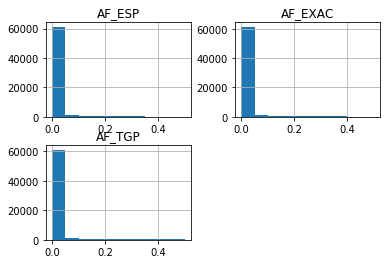

In [13]:
df[['AF_ESP', 'AF_EXAC', 'AF_TGP']].hist()

In [14]:
df['AF_ESP'] = df['AF_ESP'].apply(lambda x: 1 if x > 0 else 0).astype('category')
df['AF_EXAC'] = df['AF_EXAC'].apply(lambda x: 1 if x > 0 else 0).astype('category')
df['AF_TGP'] = df['AF_TGP'].apply(lambda x: 1 if x > 0 else 0).astype('category')

## CLNDISDB

This variable contains IDs for diseases in other databases. This variable has a large number of values, so it will be difficult to use it. I see that different values for this variable often contain the same identifiedrs, making the values arguable not unique (e.g. 'MedGen:CN169374' appears in multiple values). I choose to drop it.

In [15]:
print(len(df['CLNDISDB'].unique()))
df['CLNDISDB'].value_counts()[0:10]

9234


MedGen:CN169374                                                                                             5344
MedGen:C0027672,SNOMED_CT:699346009|MedGen:CN169374                                                         1724
MedGen:CN169374|MedGen:CN517202                                                                             1398
MedGen:C0027672,SNOMED_CT:699346009                                                                         1139
MedGen:C1837342,OMIM:608807,Orphanet:ORPHA140922|MedGen:C1858763,OMIM:604145|MedGen:CN169374                 913
MedGen:C0020445,OMIM:143890,SNOMED_CT:397915002,SNOMED_CT:398036000                                          732
MedGen:C0004135,OMIM:208900,Orphanet:ORPHA100,SNOMED_CT:68504005|MedGen:C0027672,SNOMED_CT:699346009         608
MedGen:C0027672,SNOMED_CT:699346009|MedGen:C0346153,OMIM:114480,Orphanet:ORPHA227535,SNOMED_CT:254843006     561
Human_Phenotype_Ontology:HP:0012265,MedGen:C0008780,Orphanet:ORPHA244|MedGen:CN169374           

In [16]:
df = df.drop('CLNDISDB', axis = 1)

## CLNDN

This captures the preferred disease name using the identifiers from CLNDISDB. This may be cleaner than the other variable, and is probably important for prediction, so I will attempt to clean it.

In [17]:
print(len(df['CLNDN'].unique()))
df['CLNDN'].value_counts()[0:20]

9260


not_specified                                                                                 5344
Hereditary_cancer-predisposing_syndrome|not_specified                                         1724
not_specified|not_provided                                                                    1398
Hereditary_cancer-predisposing_syndrome                                                       1139
Limb-girdle_muscular_dystrophy,_type_2J|Dilated_cardiomyopathy_1G|not_specified                913
Familial_hypercholesterolemia                                                                  732
Ataxia-telangiectasia_syndrome|Hereditary_cancer-predisposing_syndrome                         608
Hereditary_cancer-predisposing_syndrome|Familial_cancer_of_breast                              561
Ciliary_dyskinesia|not_specified                                                               526
Hereditary_cancer-predisposing_syndrome|Neurofibromatosis,_type_1                              513
Ataxia-tel

Each value is a list of diseases. It seems like I could clean this by creating dummy variables for specific common diseases in each list. I will create dummies for the top 100 diseases.

In [18]:
name_df = df['CLNDN'].str.split(pat = '|', expand = True)
name_df.head()
top_100_dn = name_df.apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)[0:100]
print(top_100_dn[0:10])

top_100_dn_list = list(top_100_dn.index)
print(top_100_dn_list[0:10])

not_specified                                    45547.0
Hereditary_cancer-predisposing_syndrome          18367.0
not_provided                                     13020.0
Hereditary_breast_and_ovarian_cancer_syndrome     2058.0
Familial_cancer_of_breast                         1977.0
Dilated_cardiomyopathy_1G                         1951.0
Limb-girdle_muscular_dystrophy,_type_2J           1920.0
Cardiovascular_phenotype                          1853.0
Hypertrophic_cardiomyopathy                       1556.0
Ataxia-telangiectasia_syndrome                    1510.0
dtype: float64
['not_specified', 'Hereditary_cancer-predisposing_syndrome', 'not_provided', 'Hereditary_breast_and_ovarian_cancer_syndrome', 'Familial_cancer_of_breast', 'Dilated_cardiomyopathy_1G', 'Limb-girdle_muscular_dystrophy,_type_2J', 'Cardiovascular_phenotype', 'Hypertrophic_cardiomyopathy', 'Ataxia-telangiectasia_syndrome']


In [19]:
for dn in top_100_dn_list:
    df[dn] = df['CLNDN'].apply(lambda x: 1 if dn in x else 0).astype('category')
df = df.drop('CLNDN', axis = 1)

In [20]:
print(df.columns)

Index(['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP', 'CLNHGVS',
       'CLNVC', 'CLNVI',
       ...
       'Ehlers-Danlos_syndrome,_type_7A', 'Cardiomyopathy',
       'Congenital_contractural_arachnodactyly',
       'Cardiomyopathy_dilated_with_woolly_hair_and_keratoderma',
       'Romano-Ward_syndrome', 'Charcot-Marie-Tooth,_Type_4',
       'PTEN_hamartoma_tumor_syndrome', 'Nemaline_Myopathy,_Recessive',
       'Renal_cell_carcinoma,_papillary,_1', 'Hereditary_cutaneous_melanoma'],
      dtype='object', length=135)


## CLNHGVS

This variable is all unique values that I don't understand related to HGVS expression. I choose to drop it.

In [21]:
print(len(df['CLNHGVS'].unique()))
df = df.drop('CLNHGVS', axis = 1)

65188


## MC

Molecular consequence is a categorical variable, need to clean up rare values. Since values are lists of consequences, I will do this similarly to how I did it for the names, splitting up the series and coding dummies.

In [22]:
df['MC'].value_counts()[0:10]

SO:0001583|missense_variant                                   23034
SO:0001819|synonymous_variant                                 16549
SO:0001627|intron_variant                                      7534
SO:0001583|missense_variant,SO:0001627|intron_variant          2422
SO:0001589|frameshift_variant                                  1622
SO:0001587|nonsense                                            1573
SO:0001627|intron_variant,SO:0001819|synonymous_variant        1148
SO:0001583|missense_variant,SO:0001623|5_prime_UTR_variant      599
SO:0001623|5_prime_UTR_variant                                  516
SO:0001575|splice_donor_variant                                 504
Name: MC, dtype: int64

In [23]:
name_df = df['MC'].str.split(pat = '[|,]', expand = True)
name_df.head()
top_mc = name_df.apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)[0:20]
print(top_mc)

top_mc_list = [x for x in list(top_mc.index) if 'SO:' not in x]
print(top_mc_list)

missense_variant           26642.0
SO:0001583                 26642.0
synonymous_variant         18379.0
SO:0001819                 18379.0
intron_variant             11967.0
SO:0001627                 11967.0
5_prime_UTR_variant         1985.0
SO:0001623                  1985.0
SO:0001589                  1861.0
frameshift_variant          1861.0
nonsense                    1783.0
SO:0001587                  1783.0
3_prime_UTR_variant          704.0
SO:0001624                   704.0
splice_donor_variant         579.0
SO:0001575                   579.0
SO:0001636                   429.0
2KB_upstream_variant         429.0
SO:0001574                   428.0
splice_acceptor_variant      428.0
dtype: float64
['missense_variant', 'synonymous_variant', 'intron_variant', '5_prime_UTR_variant', 'frameshift_variant', 'nonsense', '3_prime_UTR_variant', 'splice_donor_variant', '2KB_upstream_variant', 'splice_acceptor_variant']


In [24]:
df['MC'] = df['MC'].fillna('unknown')
for mc in top_mc_list:
    df[mc] = df['MC'].apply(lambda x: 1 if mc in x else 0).astype('category')
    print(df[mc].value_counts())
df = df.drop('MC', axis = 1)

0    38546
1    26642
Name: missense_variant, dtype: int64
0    46809
1    18379
Name: synonymous_variant, dtype: int64
0    53221
1    11967
Name: intron_variant, dtype: int64
0    63203
1     1985
Name: 5_prime_UTR_variant, dtype: int64
0    63327
1     1861
Name: frameshift_variant, dtype: int64
0    63405
1     1783
Name: nonsense, dtype: int64
0    64484
1      704
Name: 3_prime_UTR_variant, dtype: int64
0    64609
1      579
Name: splice_donor_variant, dtype: int64
0    64759
1      429
Name: 2KB_upstream_variant, dtype: int64
0    64760
1      428
Name: splice_acceptor_variant, dtype: int64


## ORIGIN

Here is the description: "Allele origin. One or more of the following values may be added: 0 - unknown; 1 - germline; 2 - somatic; 4 - inherited; 8 - paternal; 16 - maternal; 32 - de-novo; 64 - biparental; 128 - uniparental; 256 - not-tested; 512 - tested-inconclusive; 1073741824 - other" Since almost all have origin 1 (germline), I will recode this to have 0 for all other values to make it a dummy variable.

In [25]:
df['ORIGIN'] = df['ORIGIN'].fillna(0).apply(lambda x: 1 if x == 1.0 else 0).astype('category')

## Consequence

This variable is similar to MC, but with slightly different values. I'm not sure why. I will use it to update the MC dummy variables from before.

In [26]:
name_df = df['Consequence'].str.split(pat = '&', expand = True)
name_df.head()
top_mc = name_df.apply(pd.value_counts).sum(axis=1).sort_values(ascending = False)
print(top_mc[0:20])

missense_variant            32408.0
synonymous_variant          18220.0
intron_variant               7847.0
splice_region_variant        5065.0
frameshift_variant           1864.0
stop_gained                  1800.0
5_prime_UTR_variant           642.0
inframe_deletion              593.0
splice_donor_variant          584.0
3_prime_UTR_variant           435.0
splice_acceptor_variant       421.0
inframe_insertion             204.0
start_lost                    100.0
upstream_gene_variant          82.0
coding_sequence_variant        43.0
downstream_gene_variant        26.0
stop_lost                      16.0
intergenic_variant             14.0
stop_retained_variant          12.0
protein_altering_variant       10.0
dtype: float64


In [27]:
for mc in top_mc_list:
    mc2 = mc + '2'
    df[mc2] = df['Consequence'].apply(lambda x: 1 if mc in x else 0).astype('category')
    df[mc] = df[[mc, mc2]].apply(lambda x: max(x[mc], x[mc2]), axis = 1).astype('category')
    print(df[mc].value_counts())
    df=df.drop(mc2, axis = 1)


1    32783
0    32405
Name: missense_variant, dtype: int64
0    46770
1    18418
Name: synonymous_variant, dtype: int64
0    53145
1    12043
Name: intron_variant, dtype: int64
0    63132
1     2056
Name: 5_prime_UTR_variant, dtype: int64
0    63301
1     1887
Name: frameshift_variant, dtype: int64
0    63405
1     1783
Name: nonsense, dtype: int64
0    64431
1      757
Name: 3_prime_UTR_variant, dtype: int64
0    64568
1      620
Name: splice_donor_variant, dtype: int64
0    64759
1      429
Name: 2KB_upstream_variant, dtype: int64
0    64741
1      447
Name: splice_acceptor_variant, dtype: int64


## IMPACT

Categorical variable capturing variant impact

In [28]:
df['IMPACT'].value_counts()

MODERATE    33212
LOW         21642
MODIFIER     5582
HIGH         4752
Name: IMPACT, dtype: int64

In [29]:
df['IMPACT'] = df['IMPACT'].astype('category')

## SYMBOL



In [ ]:
df.info()